# Calc HRM using plons

In [1]:
import plons
import os
import numpy                    as np
import matplotlib.pyplot        as plt
# import necessary plons scripts
import plons.ConversionFactors_cgs        as cgs
import plons.GeometricalFunctions         as gf
import plons.AccrDisk                     as ad

In [2]:
'''
Calculate scale height and disk mass ifo radius, and estimate radius, using the median scale height of $numberOfThetas theta directions
Make plots
Save data in txt file

input
dumpData             input data, used for density and position
run                  modelName, used to save in correct locations
dump                 dumpNumber, used to save under correct name
'''

def fullThetaCalculations(dumpData,run,dump,xH, printOut = False):
    # Choose which and how many r and theta values you want to use to calculate scale heights and disk mass and for plot of rho vs h
    n_grid         = 10000
    maxH           = 1.5 *cgs.au

    numberOfThetas = 10
    thetaMin       = 0
    thetaMax       = 2*np.pi
    thetaArray     = np.linspace(thetaMin,(numberOfThetas-1)/numberOfThetas*thetaMax,numberOfThetas)

    crit           = 0.3
    # lowerR         = 0.1           #to test
    # r_step         = 0.1           #to test
    
    lowerR         = 0.02
    r_step         = 0.01

    # Calculate arrays with radii, disk mass, relative addes mass, and scale heights
    r_array,totalMassDisk,rel_mass_added,SH_array,Sigma_array,SigmaTheor_array,Tau_array,TauTheor_array =  ad.get_SH_diskMass_radius(lowerR,r_step,thetaArray,dumpData,maxH,n_grid,run,crit,xH,phiQuadr = False, printOut = printOut)
    
    '''
    Write data for full theta region in txt file infoAccrDisk_wind_00....txt
    '''
    testLimit = crit
    
    title = os.path.join(run,'plotsAnalysis/infoAccrDisk_wind_00'+str(dump)+'_'+xH+'.txt')
    with open (title,'w') as f:
        f.write('Model '+str(run)+'wind_00'+str(dump)+'\n')
        f.write('Data analysis accretion disks')
        f.write('\n')
        f.write('\n')    
        f.write('for rstep '+ str(r_step)+ ' au (=racc) and limit of '+ str(testLimit)+':'+'\n')
        f.write('the estimated radius is:           '+ str(np.round(r_array[np.where(rel_mass_added/r_step<testLimit)][0]/cgs.au,3))+' au'+'\n')
        f.write('the estimated total mass is:       '+ str(np.round(totalMassDisk[np.where(rel_mass_added/r_step<testLimit)][0]/cgs.Msun,11))+' Msun'+'\n')
        f.write('the estimated max scale height is: '+ str(np.round(SH_array[np.where(rel_mass_added/r_step<testLimit)][0]/cgs.au,3))+' au'+'\n')
        f.write('\n')
        f.write('\n')
        f.write('for rstep '+ str(r_step)+ ' au (=racc):'+'\n')
        names = ['r [au]', 'SH [au]', 'Mtot [Msun]', 'Mrel/rstep []', 'Sigma []','Sigma Theor []','OptDepth []','OptDepthTheor []']
        f.write("{: <30} {: <30} {: <30} {: <30} {: <30} {: <30} {: <30} {: <30}".format(*names))
        col_format = "{:<31}" * 8 + "\n"   # 5 left-justfied columns with 15 character width
        f.write('\n')
        for i in zip(np.round(r_array/cgs.au,2),np.round(SH_array/cgs.au,4),np.round(totalMassDisk/cgs.Msun,13),np.round(rel_mass_added/r_step,3),np.round(Sigma_array,4),np.round(SigmaTheor_array,4),np.round(Tau_array,3),np.round(TauTheor_array,3)):
            f.write(col_format.format(*i))

    '''
    Construct plots 
    '''
    '''
    # Make rho-h plots for each theta with varying r
    But maybe dont ;)
    '''
    # plotRhoVert_fixedTheta(r_array[::10]/cgs.au,thetaArray,dumpData,maxH,n_grid,run,xH)
    
    '''
    Make plots of relative added mass, total disk mass, and scale heights ifo r
    '''
    if xH == '1H':
        fig, axs = plt.subplots(nrows = 1, ncols= 5 , figsize=(23, 5))
    else:
        fig, axs = plt.subplots(nrows = 1, ncols= 3 , figsize=(14, 5))
    ad.plot_relAddedMass(axs[0], r_array,rel_mass_added,r_step,crit)
    ad.plot_totalDiskMass(axs[1], r_array,totalMassDisk)
    ad.plot_scaleHeights(axs[2], r_array,SH_array)
    if xH == '1H':
        ad.plot_surfDensity(axs[3],r_array,Sigma_array,SigmaTheor_array)
        ad.plot_opticalDepth(axs[4],r_array,Tau_array,TauTheor_array)
    
    return fig

In [3]:
'''
Calculate scale height and disk mass ifo radius, and estimate radius, using the median scale height of $numberOfThetas theta directions; in 4 different theta quadrants
Make plots
Save data in 4 txt files

input
dumpData             input data, used for density and position
run                  modelName, used to save in correct locations
dump                 dumpNumber, used to save under correct name
'''

def thetaRegionsCalculations(dumpData,run,dump,xH):
    '''
    Calculations of scale height, mass estimates, radius
    For 4 different theta regions
    '''

    # Choose which and how many r and theta values you want to use to calculate scale heights and disk mass and for plot of rho vs h
    n_grid         = 10000
    # maxH           = 1.5 * cgs.au    
    maxH           = 3 * cgs.au    
    numberOfThetas = 10        #Number of thetas withing one array 
    
    '''
    Divide into 4 different theta regions
    '''
    # Away from AGB
    thetaMin1      = -1./4. *np.pi
    thetaMax1      = 1./4. *np.pi
    thetaArray1    = np.linspace(thetaMin1,thetaMax1,numberOfThetas)
    # Make sure all theta's are positive
    i = 0
    for theta in thetaArray1:
        if theta < 0:
            thetaArray1[i] = thetaArray1[i]+2*np.pi
        i = i+1

    # Positive y --> bow shock side (in front of companion)
    thetaMin2      = 1./4. * np.pi
    thetaMax2      = 3./4. * np.pi
    thetaArray2    = np.linspace(thetaMin2,thetaMax2,numberOfThetas) 

    # Towards AGB 
    thetaMin3      = 3./4. * np.pi
    thetaMax3      = 5./4. * np.pi
    thetaArray3    = np.linspace(thetaMin3,thetaMax3,numberOfThetas) 

    # Negative y --> flow behind companion
    thetaMin4      = 5./4. * np.pi
    thetaMax4      = 7./4. * np.pi
    thetaArray4    = np.linspace(thetaMin4,thetaMax4,numberOfThetas)

    crit           = 0.3
    # lowerR         = 0.1           #to test
    # r_step1        = 0.1           #to test
    
    lowerR         = 0.02
    r_step1         = 0.01
    
    if run == '/lhome/jolienm/Documents/TierModels/R_Aql/cooling/binariesInPaper/finalAccrDisks/v10e00_T3000_res8_racc01/':
        r_step3        = 0.015   # Was nescessary for my model v10e00
    else:
        r_step3        = r_step1
    
    '''
    Calculate scale heights and mass estimates at each r; and estimate final radius
    Make text files with important info to make plots 
    for different theta regimes
    '''
    testLimit = crit
    # calculate scale height and mass estimates at each r for this setup
    r_array1,totalMassDisk1,rel_mass_added1,SH_array1,Sigma_array1,SigmaTheor_array1,Tau_array1,TauTheor_array1 =  ad.get_SH_diskMass_radius(lowerR,r_step1,thetaArray1,dumpData,maxH,n_grid,run,crit,xH,phiQuadr=True)
    title = os.path.join(run,'plotsAnalysis/infoAccrDisk_theta~0_wind_00'+str(dump)+'_'+xH+'.txt')
    ad.writeFile(title,r_step1,testLimit,r_array1,rel_mass_added1,totalMassDisk1,SH_array1,Sigma_array1,SigmaTheor_array1,Tau_array1,TauTheor_array1)
    
    r_array2,totalMassDisk2,rel_mass_added2,SH_array2,Sigma_array2,SigmaTheor_array2,Tau_array2,TauTheor_array2 =  ad.get_SH_diskMass_radius(lowerR,r_step1,thetaArray2,dumpData,maxH,n_grid,run,crit,xH,phiQuadr=True)
    title = os.path.join(run,'plotsAnalysis/infoAccrDisk_theta~pi:2_wind_00'+str(dump)+'_'+xH+'.txt')
    ad.writeFile(title,r_step1,testLimit,r_array2,rel_mass_added2,totalMassDisk2,SH_array2,Sigma_array2,SigmaTheor_array2,Tau_array2,TauTheor_array2)

    r_array3,totalMassDisk3,rel_mass_added3,SH_array3,Sigma_array3,SigmaTheor_array3,Tau_array3,TauTheor_array3 =  ad.get_SH_diskMass_radius(lowerR,r_step3,thetaArray3,dumpData,maxH,n_grid,run,crit,xH,phiQuadr=True)
    title = os.path.join(run,'plotsAnalysis/infoAccrDisk_theta~pi_wind_00'+str(dump)+'_'+xH+'.txt')
    ad.writeFile(title,r_step3,testLimit,r_array3,rel_mass_added3,totalMassDisk3,SH_array3,Sigma_array3,SigmaTheor_array3,Tau_array3,TauTheor_array3)

    r_array4,totalMassDisk4,rel_mass_added4,SH_array4,Sigma_array4,SigmaTheor_array4,Tau_array4,TauTheor_array4 =  ad.get_SH_diskMass_radius(lowerR,r_step1,thetaArray4,dumpData,maxH,n_grid,run,crit,xH,phiQuadr=True)
    title = os.path.join(run,'plotsAnalysis/infoAccrDisk_theta~pi3:2_wind_00'+str(dump)+'_'+xH+'.txt')
    ad.writeFile(title,r_step1,testLimit,r_array4,rel_mass_added4,totalMassDisk4,SH_array4,Sigma_array4,SigmaTheor_array4,Tau_array4,TauTheor_array4)
    
    
    '''
    Construct plots
    '''
    if xH == '1H':
        fig, axs = plt.subplots(nrows = 1, ncols= 5 , figsize=(23, 5))
    else:
        fig, axs = plt.subplots(nrows = 1, ncols= 3 , figsize=(14, 5))
        
    
    ad.plot_relAddedMass_4theta(axs[0],r_array1,r_array2,r_array3,r_array4,rel_mass_added1,rel_mass_added2,rel_mass_added3,rel_mass_added4,r_step1,r_step3,crit)
    ad.plot_totalDiskMass_4theta(axs[1],r_array1,r_array2,r_array3,r_array4,totalMassDisk1,totalMassDisk2,totalMassDisk3,totalMassDisk4)
    ad.plot_scaleHeights_4theta(axs[2],r_array1,r_array2,r_array3,r_array4,SH_array1,SH_array2,SH_array3,SH_array4)
    if xH == '1H':
        ad.plot_surfDensity_4theta(axs[3],r_array1,r_array2,r_array3,r_array4,Sigma_array1,Sigma_array2,Sigma_array3,Sigma_array4)
        ad.plot_opticalDepth_4theta(axs[4],r_array1,r_array2,r_array3,r_array4,Tau_array1,Tau_array2,Tau_array3,Tau_array4)
    return fig

In [4]:
'''
Main definition to do all calculations

input
run                  modelName, used to save in correct locations
dump                 dumpNumber, used to save under correct name
scaleHeightList      list with 1H, 2H or one of both, to know for which scale height calculations need to be done
full, quadrants      boolians to know if calculations should be done for full thetaregion and/or quadrants

'''
def main(run,dump,scaleHeightList,full=True,quadrants=True,printOut = False):
    '''
    Load in data
    '''    
    setup = plons.LoadSetup(run, "wind")
    dumpData = plons.LoadFullDump(os.path.join(run, f"wind_%05d" % dump), setup)
    
    # Coordinate transformation: translation to rcomp + rotation such that AGB is on positive x-axis
    # Coordinate transformation such that comp is at (0,0) and AGB at -x
    dumpData['new_x'],dumpData['new_y'],dumpData['new_r'] = ad.calc_new_position(dumpData['position'][:,0],dumpData['position'][:,1],dumpData)
    phi = gf.calcPhi(dumpData['new_x'],dumpData['new_y'])
    dumpData['new_Phi'] = np.where(phi < 0, phi + 2 * np.pi, phi)
    
    '''
    Test if coordinate transformation is correct
    '''   
    # testPositionAndTheta(dumpData,run,dump)

    '''
    Perform calculations for full theta region and/or 4 different theta regions; make plots and write txt files with results
    '''  
    for xH in scaleHeightList:
        if full==True:
            if printOut: print('Calculations full theta region:')
            fig = fullThetaCalculations(dumpData,run,dump,xH, printOut)
            fig.savefig(run+'plotsAnalysis/Disk_wind_%05d'%(dump)+'_'+xH+'.png', bbox_inches='tight')
        if quadrants==True:
            if printOut: print('Calculations for different theta regions:')
            fig = thetaRegionsCalculations(dumpData,run,dump,xH)
            fig.savefig(run+f'plotsAnalysis/Theta_rstep_wind_%05d'%(dump)+'_'+xH+'.png', bbox_inches='tight')

Calculations full theta region:
---------
r 0.1  au
scale height is  0.026027602760276037
mass added [Msun]:  0.0
relMass_added/rstep (rico) =  1.0
---------
r 0.2  au
scale height is  0.027302730273027292
mass added [Msun]:  6.468131334578011e-09
relMass_added/rstep (rico) =  10.0
---------
r 0.3  au
scale height is  0.03795379537953801
mass added [Msun]:  2.65079337061925e-08
relMass_added/rstep (rico) =  8.039
---------
r 0.4  au
scale height is  0.05505550555055506
mass added [Msun]:  3.1982221183316454e-08
relMass_added/rstep (rico) =  4.924
---------
r 0.5  au
scale height is  0.08205820582058203
mass added [Msun]:  2.6116913172112218e-08
relMass_added/rstep (rico) =  2.868
---------
r 0.6  au
scale height is  0.10261026102610261
mass added [Msun]:  1.7465583855585963e-08
relMass_added/rstep (rico) =  1.609
---------
r 0.7  au
scale height is  0.13306330633063307
mass added [Msun]:  1.1486228188608306e-08
relMass_added/rstep (rico) =  0.957
---------
r 0.8  au
scale height is  0.

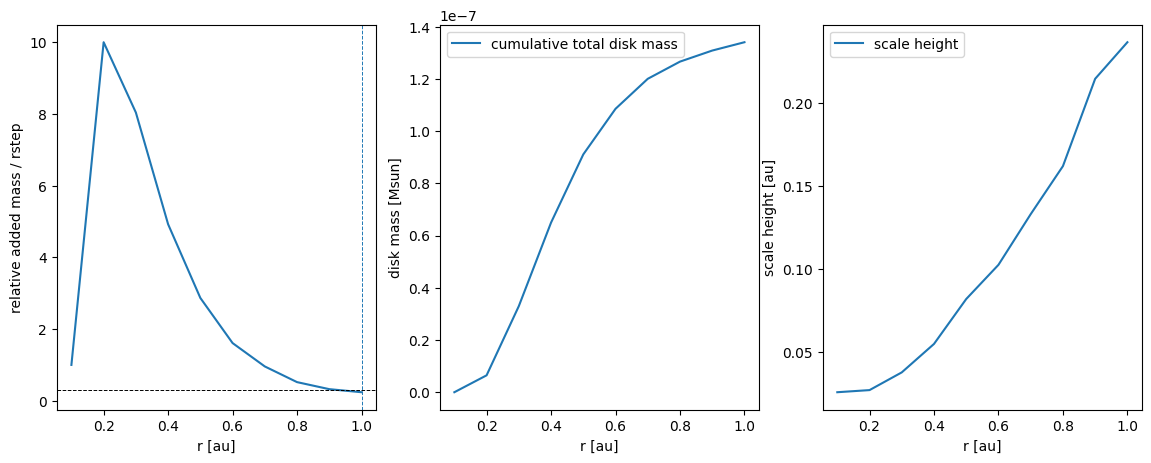

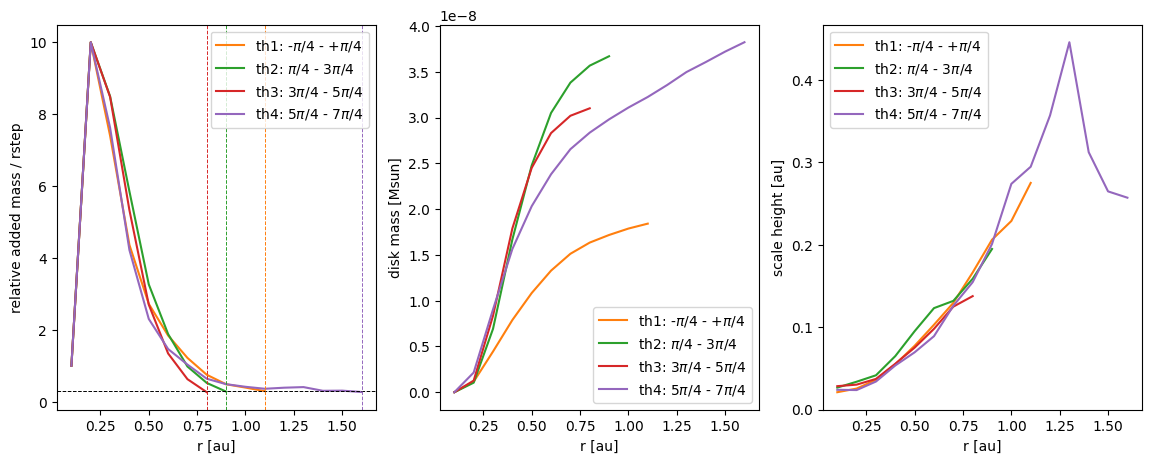

In [5]:
'''
Example
'''
run    = '/STER/matse/Phantom/Pi1Gru/Pi1Gru/'
dump = 101
main(run,dump,['1H'],full=True,quadrants=True,printOut=True)

/lhome/jolienm/anaconda3/envs/plons/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/lhome/jolienm/anaconda3/envs/plons/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


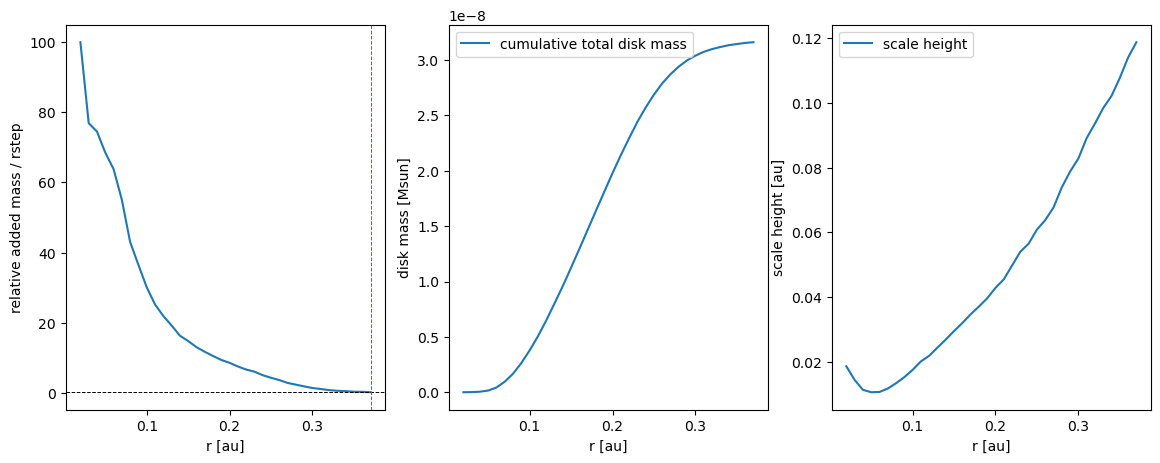

In [5]:
'''
Example
'''

dir = '/lhome/jolienm/Documents/TierModels/R_Aql/cooling/binariesInPaper/finalAccrDisks/'

#Non-eccentric runs --> use final full dump; do calculations for both scale height options and for both the full thetaregion and the four quadrants seperately to study asymmetries
run  = os.path.join(dir, 'v20e00_T3000_res8_racc01/')
dump = 292
main(run,dump,['2H'],full=True,quadrants=False)

In [ ]:
'''
Example
'''

dir = '/lhome/jolienm/Documents/TierModels/R_Aql/cooling/binariesInPaper/finalAccrDisks/'

#Non-eccentric runs --> use final full dump; do calculations for both scale height options and for both the full thetaregion and the four quadrants seperately to study asymmetries
# run  = os.path.join(dir, 'v20e00_T3000_res8_racc01/')
# dump = 292
# main(run,dump,['1H','2H'],full=True,quadrants=True)

# run  = os.path.join(dir, 'v10e00_T3000_res8_racc01/')
# dump = 292
# main(run,dump,['1H','2H'],full=True,quadrants=True)

# run  = os.path.join(dir, 'v05e00_T3000_res8_racc01/')
# dump = 292
# main(run,dump,['1H','2H'],full=True,quadrants=True)


##eccentric runs --> Select interesting dumps throughout last orbit, compare calculations for full theta region

run  = os.path.join(dir, 'v05e50_T3000_res8_racc01/')
dump = 245
# main(run,dump,['1H','2H'],full=True,quadrants=False)
dump = 263
# main(run,dump,['1H','2H'],full=True,quadrants=False)
dump = 277
main(run,dump,['1H','2H'],full=True,quadrants=False)
dump = 292
main(run,dump,['1H','2H'],full=True,quadrants=False)

run  = os.path.join(dir, 'v10e50_T3000_res8_racc01/')
dump = 245
main(run,dump,['1H','2H'],full=True,quadrants=False)
dump = 263
main(run,dump,['1H','2H'],full=True,quadrants=False)
dump = 277
main(run,dump,['1H','2H'],full=True,quadrants=False)
dump = 292
main(run,dump,['1H','2H'],full=True,quadrants=False)

run  = os.path.join(dir, 'v20e50_T3000_res8_racc01/')
dump = 250
main(run,dump,['1H','2H'],full=True,quadrants=False)
dump = 266
main(run,dump,['1H','2H'],full=True,quadrants=False)
dump = 277
main(run,dump,['1H','2H'],full=True,quadrants=False)
dump = 292
main(run,dump,['1H','2H'],full=True,quadrants=False)


/lhome/jolienm/anaconda3/envs/plons/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/lhome/jolienm/anaconda3/envs/plons/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


!! At this theta direction, you are no longer in the disk or you set your maxH too small!!
!! At this theta direction, you are no longer in the disk or you set your maxH too small!!
!! At this theta direction, you are no longer in the disk or you set your maxH too small!!
!! At this theta direction, you are no longer in the disk or you set your maxH too small!!
!! At this theta direction, you are no longer in the disk or you set your maxH too small!!
!! At this theta direction, you are no longer in the disk or you set your maxH too small!!
!! At this theta direction, you are no longer in the disk or you set your maxH too small!!
!! At this theta direction, you are no longer in the disk or you set your maxH too small!!
!! At this theta direction, you are no longer in the disk or you set your maxH too small!!
!! At this theta direction, you are no longer in the disk or you set your maxH too small!!
!! At this theta direction, you are no longer in the disk or you set your maxH too small!!

In [ ]:
run  = os.path.join(dir, 'v05e50_T3000_res8_racc01/')
dump = 263
main(run,dump,['1H','2H'],full=True,quadrants=False)

In [ ]:
run  = os.path.join(dir, 'v20e00_T3000_res8_racc01/')
dump = 292
main(run,dump,['1H','2H'],full=True,quadrants=True)